# Import Section

In [1]:
# Path
import os

# Data
import numpy as np
from tensorflow.keras.utils import plot_model

# Plot
import matplotlib.pyplot as plt

# Image
from PIL import Image # used in image processing function
from PIL import ImageFilter # used in load_image_pair()

# Tensorflow
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import load_img

# For Tensorflow Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import RandomNormal

Using TensorFlow backend.


# Colab Function

In [0]:
def gpu_check():
  """
      Check GPU RAM status. Since google colab share gpu resource amount of its
      user, you want to make sure there are enough GPU RAM that are free to use.
      Recommend at least 3000MB free GPU RAM.
  """
  # memory footprint support libraries/code
  !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
  !pip install gputil
  !pip install psutil
  !pip install humanize
  import psutil
  import humanize
  import os
  import GPUtil as GPU
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# Path Functions

In [0]:
def ensure_dir(path_to_dir):
  try:
      os.makedirs(path_to_dir)
  except FileExistsError:
      # directory already exists
      pass

# Config

In [0]:
"""
    config project in this cell.
"""

# Env, where you running this project
# Google colab: 'colab'
# local machine: 'local'
env = 'colab'


In [5]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""

# config dictionary
config = {
    'colab':{
        'data_dir':'/content/drive/My Drive/Colab Notebooks/data',
        'checkpoint_dir':'/content/drive/My Drive/Colab Notebooks/checkpoints',
        'log_dir':'/content/drive/My Drive/Colab Notebooks/logs',
        'predict_dir':'/content/drive/My Drive/Colab Notebooks/prediction',
        'result_dir':'/content/drive/My Drive/Colab Notebooks/result',
    },
    'local':{
        'data_dir': os.path.join(os.getcwd(), 'data'),
        'checkpoint_dir': os.path.join(os.getcwd(), 'checkpoints'),
        'log_dir': os.path.join(os.getcwd(), 'logs'),
        'predict_dir':os.path.join(os.getcwd(), 'prediction'),
        'result_dir':os.path.join(os.getcwd(), 'result'),
    }
}

# setting all variables
data_dir = config[env]['data_dir']
checkpoint_dir = config[env]['checkpoint_dir']
log_dir = config[env]['log_dir']
predict_dir = config[env]['predict_dir']
result_dir = config[env]['result_dir']

# mount google drive
if env == 'colab':
  # Google Drive
  from google.colab import drive
  # mount google dirve
  drive.mount('/content/drive')
  # ensure dir exsits
  ensure_dir(checkpoint_dir)
  # check GPU
  # gpu_check()
  
# make sure dir exist
ensure_dir(checkpoint_dir)
ensure_dir(log_dir)
ensure_dir(predict_dir)
ensure_dir(result_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Image Processing Function

In [0]:
def bicubic_rescale(image, scale):
  """
      Rescale image using bicubic interpolation.
      
      Args:
        image: image
        scale: use integer for up scaling. use 1/integer for down scaling
  """
  # make sure scale is valid
  if isinstance(scale, (float, int)):
    size = (np.array(image.size) * scale).astype(int)
  '''
  WARNING
  image.resize might lead to image displacement
  https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35
  switch to tf.image.resize_bicubic
  '''
  return image.resize(size, resample=Image.BICUBIC)


def modcrop(image, scale):
  """
      To scale down the original image, there must be no remainder while scaling
      operation.
      
      All we want to do in here is to subtract the remainder from height and 
      width of original image size, and cut the original image to the new size.
      
      Args:
        image: original image
        scale: must be int
  """
  if not isinstance(scale, int):
    raise Exception('utils.modcrop: scale must be int')
  size = np.array(image.size)
  size -= size % scale
  return image.crop([0, 0, *size])

# Data Preprocessing

In [0]:
def load_image_pair(path, scale=3, greyscale=False, same_size=False):
  """
      Down scaling a hight resolution image to a low resolution image and
      return both of them.
      
      Args:
        path: image path
        scale: scale of down scaling, must be a int
        greyscale: return only Y channel
  """
  image = load_img(path)
  
  if greyscale:
    image = image.convert('YCbCr')
    Y, Cb, Cr = image.split()
    image = Y
  else:
    image = image.convert('RGB')

  hr_image = modcrop(image, scale)
  lr_image = hr_image.filter(ImageFilter.GaussianBlur(radius=2))
  lr_image = bicubic_rescale(lr_image, 1 / scale)
  lr_image = bicubic_rescale(lr_image, scale)
  return lr_image, hr_image


# def random_crop(lr_image, hr_image, random_crop_size):
#   """
#       randomly crop both lr and hr image at the same position.
      
#       Args:
#           random_crop_size: size of sub image, array, example:[32,32]
#   """
#   # Note: image_data_format is 'channel_last'
#   height, width = lr_image.size
#   dy, dx = random_crop_size
#   x = np.random.randint(0, width - dx + 1)
#   y = np.random.randint(0, height - dy + 1)
#   return lr_image.crop([x, y, x + dx, y + dy]), hr_image.crop([x, y, x + dx, y + dy])

def random_crop(image, random_crop_size):
  """
      randomly crop both lr and hr image at the same position.
      
      Args:
          random_crop_size: size of sub image, array, example:[32,32]
  """
  # Note: image_data_format is 'channel_last'
  height, width = image.size
  dy, dx = random_crop_size
  x = np.random.randint(0, width - dx + 1)
  y = np.random.randint(0, height - dy + 1)
  return image.crop([x, y, x + dx, y + dy])


def generate_sub_images(image, size, stride):
  """
      Cut image into sub images.
      
      Args:
        image: image
        size: size of sub image
        stride: distance of how much the window shifts by in each of the 
                dimensions
  """
  for i in range(0, image.size[0] - size + 1, stride):
        for j in range(0, image.size[1] - size + 1, stride):
            # yield return a generator, or a list of number
            yield image.crop([i, j, i + size, j + size])
            
            
class Dataset:
  
  def __init__(self):
    self.lr_sub_size = 0
    self.lr_sub_stride = 0
    self.hr_sub_size = 0
    self.hr_sub_stride = 0
    self.lr_array = []
    self.hr_array = []
    self.greyscale = False
    
    
  def load_set(self, dataset_name, greyscale=False):
    """
        Load all image from a directory.

        Args:
          dataset_name: name of dir of the data set
          lr_sub_size: low resolution sub image size
          lr_sub_stride: stride when crop sub image
          scale: down scale value
          same_size: hr, lr have the same size
          greyscale: return only Y channel
    """
    self.greyscale = greyscale
    
    for file_name in os.listdir(os.path.join(data_dir, dataset_name)):
      path = os.path.join(data_dir, dataset_name, file_name)
      lr_image, hr_image = load_image_pair(str(path), scale=scale, greyscale=greyscale, same_size=same_size)
      self.lr_array.append(lr_image)
      self.hr_array.append(hr_image)
      
      
  def show_set(self):
    """
      view the first 3 image of the dataset
    """
    if self.greyscale:
      colormap = 'gray'
    else:
      colormap = None
      
    f, axarr = plt.subplots(2, 3, figsize=(18,18))
    
    # Plot images in subplot
    axarr[1,2].imshow(self.hr_array[0], cmap=colormap)
    axarr[1,1].imshow(self.hr_array[1], cmap=colormap)
    axarr[1,0].imshow(self.hr_array[2], cmap=colormap)
    axarr[0,2].imshow(self.lr_array[0], cmap=colormap)
    axarr[0,1].imshow(self.lr_array[1], cmap=colormap)
    axarr[0,0].imshow(self.lr_array[2], cmap=colormap)
    
    # Disable axis
    axarr[1,2].axis("off")
    axarr[1,1].axis("off")
    axarr[1,0].axis("off")
    axarr[0,2].axis("off")
    axarr[0,1].axis("off")
    axarr[0,0].axis("off")
   
    plt.show()
    
  
  def sub_image_set(self, lr_sub_size, lr_sub_stride, scale, same_size=False, random_crop_size=[32,32], num_of_image=1, 
                    randomly_crop=False):
    """
      return the sub image dataset
    """
    if not all(isinstance(i, int) for i in [lr_sub_size, lr_sub_stride, scale]):
      raise Exception('utils.load_set: lr_sub_size, stride, scale must be int')
    
    if randomly_crop:
      lr_sub_arrays = []
      hr_sub_arrays = []
      lr_batch = []
      hr_batch = []
      height, width = self.hr_array[0].size
      dy, dx = random_crop_size

      # crop low resolution image and high resolution image at same position
      for lr_image, hr_image in zip(self.lr_array, self.hr_array):
        for i in range(num_of_image):
          x = np.random.randint(0, width - dx + 1)
          y = np.random.randint(0, height - dy + 1)

          lr_batch += [lr_image.crop([x, y, x + dx, y + dy])]
          hr_batch += [hr_image.crop([x, y, x + dx, y + dy])]

        lr_sub_arrays += [img_to_array(img) for img in lr_batch]
        hr_sub_arrays += [img_to_array(img) for img in hr_batch]

      # convert list to np.array
      x = np.stack(lr_sub_arrays)
      y = np.stack(hr_sub_arrays)

      return x, y 
    else:
      lr_sub_arrays = []
      hr_sub_arrays = []
      
      # compute parameters for high resolution image
      if same_size:
        hr_sub_size = lr_sub_size
        hr_sub_stride = lr_sub_stride
      else:
        hr_sub_size = lr_sub_size * scale
        hr_sub_stride = lr_sub_stride * scale
    
      for lr_image, hr_image in zip(self.lr_array, self.hr_array):
        lr_sub_arrays += [img_to_array(img) for img in generate_sub_images(lr_image, size=lr_sub_size, stride=lr_sub_stride)]
        hr_sub_arrays += [img_to_array(img) for img in generate_sub_images(hr_image, size=hr_sub_size, stride=hr_sub_stride)]

      # convert list to np.array
      x = np.stack(lr_sub_arrays)
      y = np.stack(hr_sub_arrays)

      return x, y 

  def clear_set(self):
    """
      reset Dataset
    """
    self.lr_array = []
    self.hr_array = []
    
    


# Helper Function

In [0]:
def train(
    model,
    train_set,
    val_set,
    epochs=1,
    steps_per_epoch=30,
    validation_steps=3,
    resume=True):
  """
    train function for all model.
    
    
  """
  path_to_weight_file = os.path.join(checkpoint_dir,model.name)

  # define callbacks
 
    # Save checkpoints of model at regular intervals
  callbacks = [
    # Save checkpoints of model at regular intervals
    tf.keras.callbacks.ModelCheckpoint(
        filepath=path_to_weight_file,
        save_best_only=True
    ),
    # Write TensorBoard logs to `./logs` directory
      tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  ]
  
  # inherit weights
  
  if resume:
    reload_model(model)
  
  # Train
  #callbacks.set_model(model)

  history = model.fit(train_set, epochs=epochs,verbose=0, callbacks=callbacks, steps_per_epoch=steps_per_epoch,
            validation_data=val_set, validation_steps=validation_steps)
  


  # plot metrics
  plot_based_loss(history)
  plot_based_accuracy(history)
  
  

def test(model, test_set, steps=30, metrics=None):
  # test
  
  reload_model(model)  
  model.evaluate(test_set, steps=steps)
  
  
def predict(model, greyscale):
  """
  """
  crop_arrays = []
  predict_arrays = []
  result_images = []
  
  # Load images from predict directory
  dataset = Dataset()
  dataset.load_set(predict_dir, greyscale)
  
  # Crop images 
  crop_arrays += [random_crop(img, [32, 32]) for img in dataset.hr_array]
  
  # Convert each image array to a 4D array
  predict_arrays += [img_to_array(img) for img in crop_arrays]
  for i in range(len(predict_arrays)):
    predict_arrays[i] = np.expand_dims(predict_arrays[i], axis=0)

  result_arrays = model.predict(predict_arrays)
  
  result_images += [array_to_img(arr) for arr in result_arrays]
  
  for i in range(len(result_images)):
    filename = str(i) + '.bmp'
    result_images[i].save( os.path.join(result_dir, filename) )
  
  
def reload_model(model):
  """
    load weight into model
  """
  try:
    print("Reading {} checkpoints...".format(model.name))
    path_to_weight_file = os.path.join(checkpoint_dir,model.name)
    model.load_weights(path_to_weight_file)
    
  except:
    raise Exception("Fail to load weight on model.")
  
def plot_based_loss(history):
  """
    Plot training & validation loss values
    history: a dictionary recording training loss values and metrics values at successive epochs
  """
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss: Mean Squared Error')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.ylim(0,2000)
  plt.show()
  
def plot_based_accuracy(history):
  """
    Plot training & validation accuracy values
    history: a dictionary recording training loss values and metrics values at successive epochs
  """
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy: Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# Model

In [0]:
class SRCNN:
  """
    name: the name of the model
    img_size: the size of the input image
    channel: the number of channels in the input image
    f1: the size of filter (must be odd #)
    n1: the number of filters apply on layer 1
    n2: the number of filters apply on layer 2
    f3: the size of filter (must be odd #)


    from: https://arxiv.org/abs/1501.00092
  """ 
  def build_model(size=[32, 32], padding=True,channel=1, f1=9, n1=64, n2=32, f3=5):
    if padding:
      padding = 'same'
    else:
      padding = 'valid'
    
    model = Sequential(name='srcnn')
    initializer = RandomNormal(mean=0.0, stddev=0.001)
    model.add(Conv2D(filters=n1, kernel_size=f1, padding=padding, activation='relu',
                     kernel_initializer=initializer, input_shape=(size[0], size[1], channel)))
    model.add(Conv2D(filters=n2, kernel_size=1, padding=padding, activation='relu',
                    kernel_initializer=initializer))
    model.add(Conv2D(filters=channel, kernel_size=f3, padding=padding, activation='linear',
                    kernel_initializer=initializer))
  
    # either SGD or Adam
    #optimizer = SGD(lr=0.0003)
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['acc'])
      
    return model
    

    


# Model Training

## Model Config

In [25]:
# size of sub image
size = 32

# strde when crop image
stride = 14

# upscaling factor
scale = 3

# batch size
batch = 32

# size of low resolution and high resolution image is the same?
same_size = True

# randomly crop image
randomly_crop = False

# number of sub image of each image
num_of_image = 30

# greyscale ON or OFF? if ON, img will only contain Y channel
greyscale = True

# which training dataset you want to use?
train_dataset_dir = '91-image'

# which validation dataset you want to use?
val_dataset_dir = 'Set5'

# which testing dataset you want to use?
test_dataset_dir = 'Set14'

# set valid padding when training
no_padding = False

# which model you want to train or test?
model_training = SRCNN.build_model([size, size])
model_testing = SRCNN.build_model([size, size])

# print model details below
print("Model Name: {}".format(model_training.name))
model_training.summary()


# epochs
epochs = 10

# steps_per_epoch
steps_per_epoch = 30

# validation_steps
validation_steps = 3

# resume last traning?
resume = False
    

Model Name: srcnn
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        5248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


## Make Data

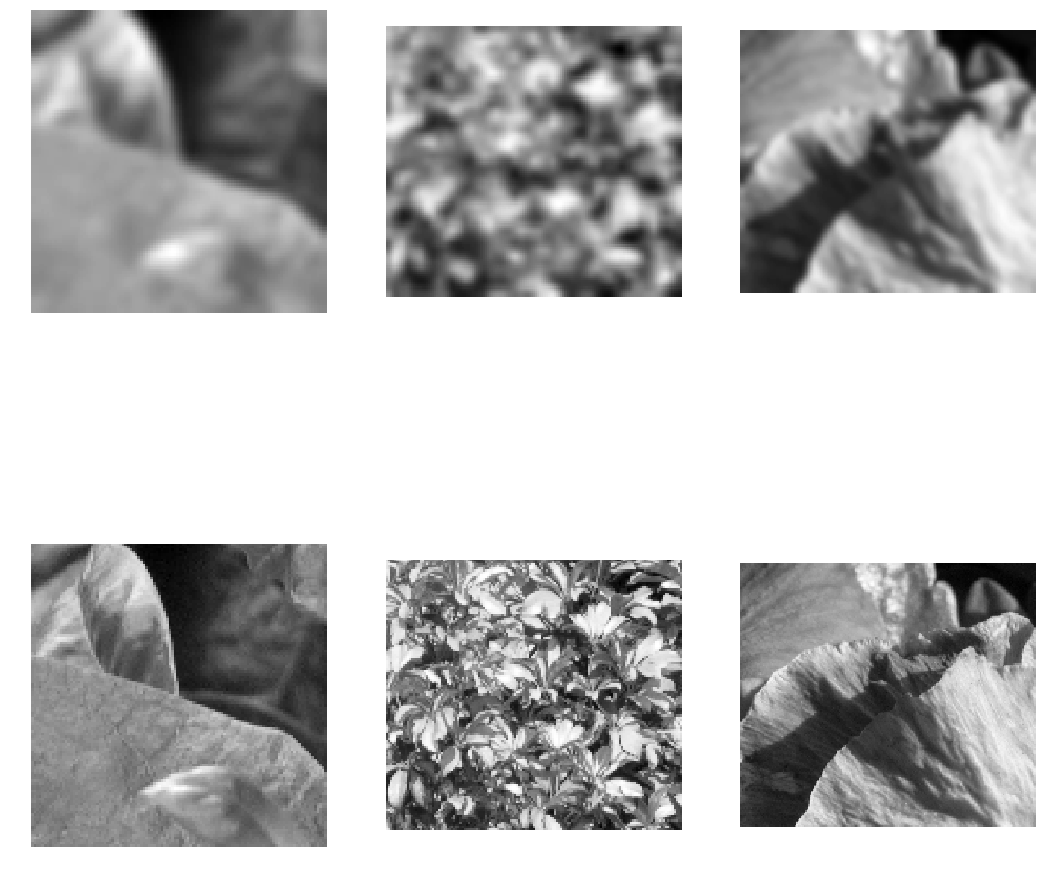

In [26]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
dataset = Dataset()

# load tranning dataset
dataset.load_set(train_dataset_dir, greyscale)
dataset.show_set()
train_lr, train_hr = dataset.sub_image_set(size, stride, scale, same_size, [size, size], num_of_image, randomly_crop)

# make tf.data dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_lr, train_hr))
train_dataset = train_dataset.batch(batch)
train_dataset = train_dataset.repeat()

# load validation dataset
dataset.clear_set()
dataset.load_set(val_dataset_dir, greyscale)
val_lr, val_hr = dataset.sub_image_set(size, stride, scale, same_size, [size, size], num_of_image, randomly_crop)

# make tf.data dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_lr, val_hr))
val_dataset = val_dataset.batch(batch//10)
val_dataset = val_dataset.repeat()

In [27]:
train_lr[0].shape

(32, 32, 1)

Instructions for updating:
Use tf.cast instead.


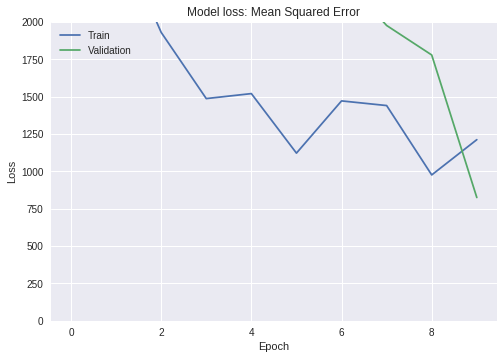

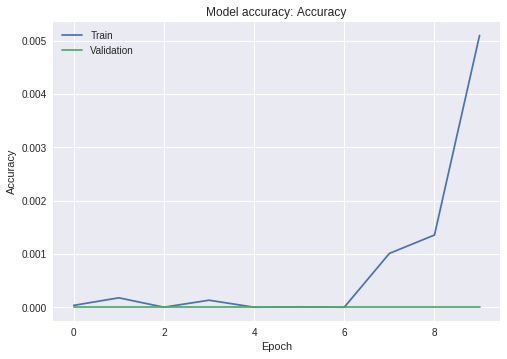

In [28]:
""" 
    _________
    | Train |
    ————-
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
train(model_training, train_dataset, val_dataset, epochs, steps_per_epoch, validation_steps, resume)

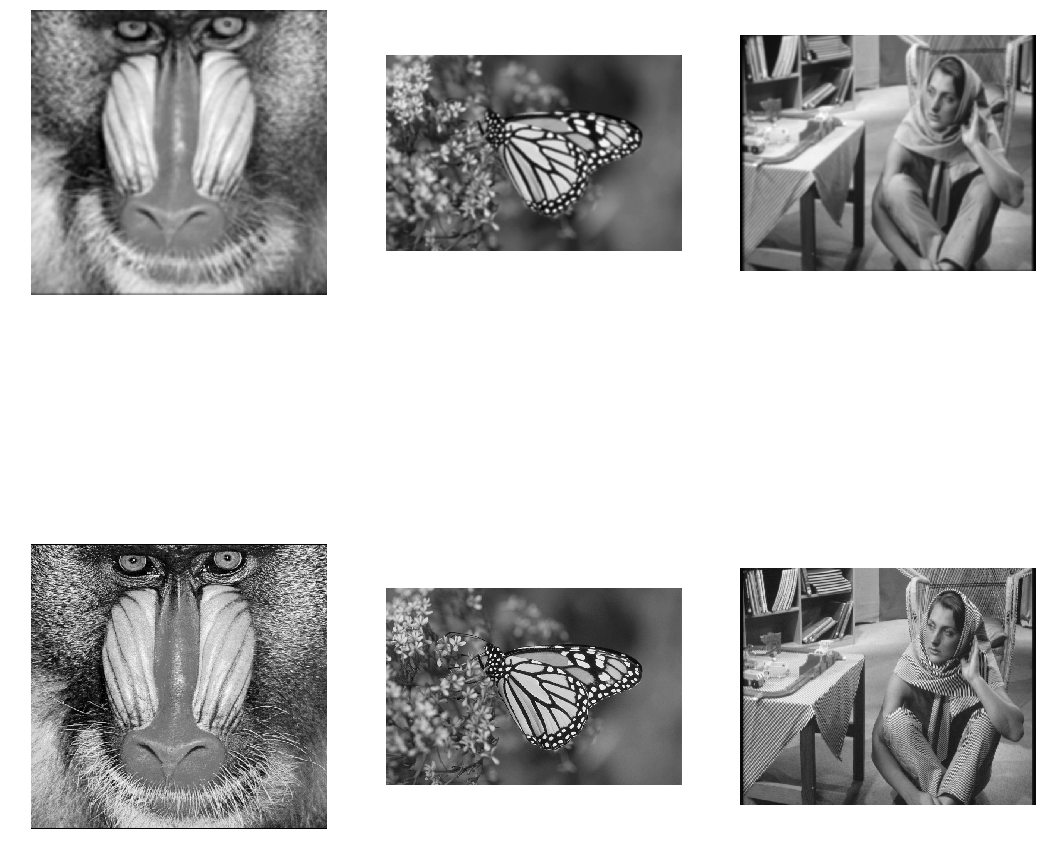

In [29]:
""" 
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
dataset = Dataset()

# load test dataset
dataset.load_set(test_dataset_dir, greyscale)
dataset.show_set()
test_lr, test_hr = dataset.sub_image_set(size, stride, scale, same_size, [size, size], num_of_image, randomly_crop)

# make tf.data dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_lr, test_hr))
test_dataset = test_dataset.batch(batch)
test_dataset = test_dataset.repeat()

In [30]:
""" 
    _________
    | Test  |
    —————————
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
test(model_testing, test_dataset, steps=30, metrics=None)

Reading srcnn checkpoints...
30/30 [==============================] - 0s 7ms/step - loss: 922.7685 - acc: 0.0000e+00


In [31]:
""" 
    _______________
    | Prediction  |
    ———————————————
     _______________________________________________
    | YOU SHOULD NOT CHANGE ANY THING IN THIS CELL. |
    |_______________________________________________|
"""
predict(model, greyscale)

NameError: ignored